# Redes Neuronales Convolucionales (CNN)

Como ya se ha menciona anteriormente, las CNN son la topología más utilizada cuando se habla de procesamiento de imágenes.

En este ejemplo abordaremos el uso y construcción de una CNN para realizar la clasificación de algunas imágenes. Estaremos utilizando *Pytorch* que es un *framework* de inteligencia artificial de código abierto, de fácil uso y que nos ahorra tiempo al momento de programar.

## Instalando Pytorch

Se puede instalar *pytorch* desde el entorno de **conda** con el siguiente comando:

**Windows**

* con cuda: **conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch**
* sin cuda: **conda install pytorch torchvision torchaudio cpuonly -c pytorch**

o utilizando **pip**:

* con cuda: **pip3 install torch==1.8.1+cu102 torchvision==0.9.1+cu102 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html**
* sin cuda: **pip3 install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html**

**Mac**

**conda**

* **conda install pytorch torchvision torchaudio -c pytorch**

o utilizando **pip**:

* **pip3 install torch torchvision torchaudio**

**Linux**

**conda**

* con cuda: **conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch**
* sin cuda: **conda install pytorch torchvision torchaudio cpuonly -c pytorch**

o utilizando **pip**:

* con cuda: **pip3 install torch torchvision torchaudio**
* sin cuda: **pip3 install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html**



Los comandos previstos son para instalar la misma versión que la utilizada en este ejemplo. Para una versión diferente, consulte en https://pytorch.org/ .

## Librerías a utilizar

Una vez instalado *pytorch* comencemos con el ejemplo. Tenemos imágenes de perros y gatos, en este ejemplo, crearemos una red neuronal que sea capaz de clasificarlos en estas dos clases.

Comenzaremos importando librerías de utilidad, como numpy, matplotlib, torch, torchvision y algunos otros módulos de torch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import random_split

## Preprocesamiento de los datos

Lo siguiente es crear un diccionario, que nos servirá más adelante, al momento de clasificar las imágenes. Este diccionario contendrá dos valores: 0 y 1, que apuntarán a Gato y No es gato, respectivamente.

In [2]:
clases = dict({0:"Gato", 1:"No es gato"})
clases

{0: 'Gato', 1: 'No es gato'}

Lo siguiente es cargar el dataset de imágenes, para esto, utilizaremos las funcionalidades de **torchvision**, la primera proviene de **dataset** y nos permite cargar un directorio de imágenes, esta funcionalidad trabaja con la segunda, que es, **transforms**. Con **transforms** podemos implementar cambios en las imágenes con el fin de estándarizarlas y algunos otros cambios que pueden resultar útiles.

Cabe mencionar que si las imágenes son en blanco y negro, tendrán 1 canal, mientras que si son a color tendrán 3 canales (RGB). Esto será importante al momento que tengamos que considerar las dimensiones que se esperan de nuestras imágenes. En nuestro caso estamos utilizando imágenes a color.

![canales](canales.png)

Hay que hacerle ciertas preparaciones a las imágenes que se pretenden usar, lo mínimo que debería hacerse, es aplicar ***RandomResizedCrop***, para que las imágenes tengan el mismo tamaño (recibe como parámetro el tamaño deseado en píxeles), ***ToTensor***, que convierte las imágenes en ***tensores***, y ***Normalize***, que nos sirve para normalizar los ***tensores***. En nuestro caso, hemos agregado dos métodos más, ***RandomRotation***, que gira las imágenes *x* grados (recibe como parámetro el número de grados a girar), y ***RandomHorizontalFlip***, que aleatoriamente, voltea una imagen horizontalmente. Estos dos últimos métodos no es estrictamente necesario que se apliquen, pero, es una buena práctica, para que nuestra red, pueda reconocer las imágenes en cualquier posición u orientación.

Ahora, los ***tensores***, mencionados anteriormente, son la base de *pytorch*, todas las operaciones que realiza *pytorch* son hechas con ***tensores***. Son muy parecidos a los ***array*** de *numpy*, tanto así que se pueden transformar ***arrays*** a ***tensores*** de una manera sumamente fácil.

In [3]:
# ejemplo de un tensor
torch.tensor([1, 2, 3, 3])

tensor([1, 2, 3, 3])

Cargamos la ubicación del directorio que contiene las imágenes, dentro de este directorio existen dos más, en uno están las imágenes de gatos y en el otro hay imágenes random, todas estas imágenes se van a cargar en lo que será nuestro **dataset** y se creará una etiqueta automática, dependiendo de que en que subdirectorio se encuentren, será 0 para el directorio de gatos y 1 para el directorio de imágenes random.

In [4]:
# directorio de las imagenes
dataset_dir = "Gatos"
# ajustamos las imagenes
transformadas = transforms.Compose([transforms.RandomRotation(30),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])

# cargamos el dataset de imagenes
dataset = datasets.ImageFolder(dataset_dir, transform=transformadas)

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: Gatos
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Podemos ver que nuestro **dataset** contiene 2000 imágenes, 1000 de gatos y 1000 random.

Ya que tenemos nuestro **dataset**, crearemos tres conjuntos, uno de entrenamiento, uno de validación y uno de prueba. Los crearemos de tal modo que el 15% del **dataset** serán datos de prueba, otro 15% serán datos de validación y el restante 70% serán datos de entrenamiento.

In [6]:
# dividimos el dataset en conjuntos de entrenamiento, validación y prueba

# tamaño del dataset
len_dataset = len(dataset)
# definimos el tamaño de los datos de entrenamiento (70% del dataset)
len_entre = int(len_dataset * 0.7)
# definimos el tamaño de los datos de prueba
len_prueba = int((len_dataset - len_entre)/2)
# tamaño del set de validación
len_val = len_dataset - len_entre - len_prueba
# creamos los conjuntos de entrenamiento, validación y prueba
entrenamiento, validacion, prueba = random_split(dataset, (len_entre, len_val, len_prueba))

Lo siguiente es que usaremos un tipo de objeto llamado ***data loader***, que nos permitirá dividir los datos en lotes o **batches**, y nos permitirá cargar la información más rápidamente. Para el conjunto de entrenamiento, crearemos *batches* de 64, mientras que para los conjuntos de prueba y validación no crearemos *batches* (que es lo mismo que tener *batches* de 1). Por último, mandaremos *shuffle* como verdadero para que ordene de manera aleatoria los datos de cada conjunto.

In [7]:
# definimos el dataloader con los datos de entrenamiento
loader_entrenamiento = torch.utils.data.DataLoader(entrenamiento, batch_size=64, shuffle=True)
# definimos el dataloader con los datos de validacion
loader_validacion = torch.utils.data.DataLoader(validacion, batch_size=1, shuffle=True)
# definimos el dataloader con los datos de prueba
loader_prueba = torch.utils.data.DataLoader(prueba, batch_size=1, shuffle=True)

Ya hemos terminado de hacer el preprocesamiento de los datos y estamos listos para diseñar nuestra red.

## Construcción del modelo

*Pytorch* nos permite crear redes personalizadas (con las capas que queramos), gracias a su clase **Module**. **Module** nos permite heredar todos los métodos que contienen las redes neuronales de *pytorch*. Así que, para crear una red propia, basta con crear una clase hija de **Module**. En nuestro caso crearemos la clase **CNN**.

Para que nuestra clase funcione adecuadamente, se necesitan implementar al menos dos métodos, el primero es el **"constructor"**, donde se crea la arquitectura de la red, definiendo las capas del modelo, y el segundo es el método ***forward***, que es donde se define como debe calcularse la entrada que se le dé al modelo.

Para declarar las capas de nuestro modelo se pueden declarar cada una como un atributo del modelo, o se puede utilizar la función ***Sequential***, que nos permite agrupar las capas del modelo, aunque hacer esto no es necesario, nos sirve para que visiblemente sea más ordenado.

Para construir nuestra red nos vamos a basar en la arquitectura de la red **AlexNet**, la cual, fue la ganadora en el  Concurso de reconocimiento visual a gran escala de ImageNet (ILSVRC) 2012. Podemos ver desde *torchvision* la estructura de esta red.

In [8]:
models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Vemos que esta dividida en 2 partes, *features* y *classifier*, *features* esta compuesta de capas convolucionales, ReLU y *max pooling*, mientras que *classifier*, esta compuesta por capas lineales, ReLU y contiene *Dropouts*.

La capa convolucional (**Conv2d**), recibe varios parámetros, el primero es el número de canales de entrada, como estamos utilizando imágenes a color, este valor será 3, luego son los canales que queremos de salida, para este caso son 64. Después viene el ***kernel_size*** o tamaño del filtro. Este filtro es el que se encargará de recorrer toda la imagen con el único propósito de recolectar la información más importante de la imagen. Seguido, tenemos el ***stride*** o zancada, que es el número de pixeles que avanza el filtro cada que se mueve, y por último tenemos el ***padding*** o relleno, que es agregar información en los bordes de la imagen.

El ***kernel*** es el filtro que irá recorriendo la imagen para aplicar la convolución y obtener información de los píxeles que abarca. Un ***kernel*** de 4x4 será un filtro de 16 píxeles, mientras que uno de 3x3, será un filtro de 9 píxeles.

![kernel](kernel.png)

El ***stride*** se refiere a cuantos píxeles avanzará el ***kernel*** cada vez, tanto horizontalmente como verticalmente. Un ***stride*** pequeño, tardará más en recorrer la imagen y recabará más información, mientras que uno grande, recorrerá la imagen en poco tiempo, pero, recabará menos información. En los ejemplos de abajo se muestra una "imagen" de 8x8, en el primer ejemplo se le está aplicando un ***kernel*** de 4x4 y un ***stride*** de 2x2, al finalizar el proceso, se ha condensado la información en 9 píxeles. Mientras que en el segundo ejemplo, se tiene la misma imagen con el mismo ***kernel***, pero con un ***stride*** de 4x4, en esta ocasión, observamos que se ha condensado la información en 4 píxeles.

![stride2x2](stride2_2.png)

![stride4x4](stride4x4.png)

El ***padding***, es la cantidad de píxeles extra que se le agregan a la imagen original, normalmente se rellenan con 0, aunque, se pueden poner valores personalizados. El ***padding*** se utiliza para que el ***kernel*** pueda obtener más información de la imagen al tener una superficie mayor por la cual moverse.

![padding](padding.png)

Después tenemos un *MaxPooling* que hace que disminuya la dimensión de la imagen, reduciendo los píxeles de la misma. Esto lo logra por la operación que emplea, operación que permite que nos quedemos con la información más importante y se deseche la demás. Además, esta operación se realiza utilizando un filtro con dilatación, que es un filtro con espacios entre sus píxeles.

![maxpool](maxpool.png)

Un ***kernel*** con dilatación es un filtro de tamaño *n x m* que deja cierto espacio entre los píxeles, de modo que no todo lo que este dentro del ***kernel*** se tomará como información, solo los píxeles seleccionados. En la imagen de abajo podemos ver un ***kernel*** de 5x5 con una dilatación de 1.

![dilation](dilation.png)

Algo que es fundamental, es que, cuando se pasa de una capa hacia otra, los canales de salida de la primera deben ser los canales de entrada de la segunda, de otro modo nuestra red no funcionará.

Durante la primera etapa vemos que tenemos 5 capas convolucionales y, después, tenemos un *adaptive average pooling*, que a diferencia del *max pooling* donde configurabamos el *kernel* y los demás hiperparámetros, aquí solamente especificamos el tamaño de la salida que queremos y se asignan los hiperparámetros de manera automática.

En la segunda parte tenemos lo que es el clasificador (perceptrón multicapa), lo que nos dirá a que clase pertenecen nuestras imágenes. El clasificador contiene algunos *Dropouts*, que eliminan algunos datos de forma aleatoria, poniéndolos en 0, con el fin de evitar el sobre entrenamiento. A los ***dropouts*** se les manda la probabilidad con la que eliminarán información, en un rango de 0 a 1.

En el modelo original de **AlexNet** se tienen como salida 1000 neuronas, utilizadas para clasificar imágenes en 1000 clases distintas, dado que nosotros solo tenemos 2 clases distintas, modificaremos la salida a 2 neuronas. También modificaremos un poco la estructura del clasificador, en nuestro caso solo tendremos una capa linear, una ReLU, un *dropout* de 0.5 y, por último, una capa linear.

In [9]:
# creamos nuestro modelo personalizado
class CNN(torch.nn.Module):

    # constructor
    def __init__(self):
        super().__init__()
        # parte convolutiva
        self.convolutiva = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.AdaptiveAvgPool2d(output_size=(6, 6))
        )
        # clasificador
        self.clasificador = nn.Sequential(
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.convolutiva(x)
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = self.clasificador(x)
        return x

Finalmente la en la función ***forward*** enviamos las imágenes primero a las capas convolucionales y después a al clasificador o capas totalmente conectadas, pero antes de enviarlas aquí es importante que "aplanemos" los tensores, de modo que, se tenga una sola dimensión, de otra forma no se podrá realizar la clasificación.

Ya creada nuestra clase, vamos a instanciarla, pero antes vamos a utilizar una funcionalidad más de pytorch, vamos a emplear la gpu para realizar los cálculos de manera más rápida si es que tenemos alguna disponible; usaremos **torch.device** para seleccionar un dispositivo, ya sea una gpu (si hay una disponible) o la cpu (en caso de que no haya cpu), y definimos el criterio de la función de pérdida, y también elegiremos el algoritmo optimizador de la red, nosotros escogeremos *CrossEntropyLoss* como función de pérdida y *SGD* (gradiente descendente estocástico).

Nuestro optimizador recibe como parámetros los parámetros de nuestra red (**cnn.parameters**) para ir actualizando los pesos de las capas, y también recibe la tasa de aprendizaje, *learning rate*.

In [10]:
# usamos una gpu si es que hay alguna disponible
# disp = torch.device("cuda" if torch.cuda.is_available() else "cpu")

disp = torch.device("cpu")

# instanciamos nuestra
cnn = CNN().to(disp)
# funcion de perdida
# criterio = nn.NLLLoss()
criterio = nn.CrossEntropyLoss()
# optimizador
optimizador = torch.optim.Adam(cnn.parameters(), lr=0.00001)

## Entrenamiento del modelo

En esta parte, lo primero que crearemos será una función para evaluar la exactitud del modelo. Esta función nos servirá después en la función de entrenamiento.

Definimos nuestra función **evaluar** que recibe como parámetros la red (**modelo**), un objeto tipo *data loader* (**prueba**), el dispositivo donde se trabajará (**disp**) y tiene un parámetro opcional que es **mostrar**, por defecto, mostrar es *False*, si lo cambiamos a *True* nos imprimirá la exactitud al termino de la función, si no, nos retornará la exactitud.

Empezamos la función, poniendo en modelo en modo de evaluación, despues inicializamos dos variables, **correctas** y **total**, en las que llevaremos el conteo de las predicciones correctas y el total de datos, respectivamente. Después vamos obteniendo las imágenes y sus etiquetas iterando el *data loader*, copiamos esos datos al dispositivo elegido previamente y ejecutamos el modelo con estas entradas, a continuación, obtenemos la clase a la que pertenecen y vamos sumando el total de datos y el total de datos correctos, finalmente, calculamos la exactitud de nuestro modelo. Para obtener la pérdida hacemos algo similar, vamos obteniendo la pérdida de cada imagen, las sumamos y al final las promediamos.

In [11]:
def evaluar(modelo, prueba, disp, criterio, mostrar=False):

    # ponemos el modelo en modo de evaluacion
    modelo.eval()
    # inicializamos variables
    correctas = 0
    total = 0
    perdida_val = 0.0
    # obtenemos los datos del data loader
    for imagenes, etiquetas in iter(prueba):
        # copiamos los datos al dispositivo seleccionado (gpu o cpu)
        imagenes = imagenes.to(disp)
        etiquetas = etiquetas.to(disp)

        # obtenemos las salidas del modelo
        salidas = modelo(imagenes)

        # obtenemos las predicciones seleccionando la clase con la
        # mayor probabilidad
        predichos = torch.max(salidas.data, 1)[1]

        # acumulamos el número de datos
        total += len(etiquetas)

        # pérdida
        perdida_val += criterio(salidas, etiquetas).data
        # acumulamos las predicciones correctas
        correctas += (predichos == etiquetas).sum()

    perdida_val = float(perdida_val/float(total))
    perdida_val = round(perdida_val, 4)
    # calculamos la exactitud
    exactitud = 100 * correctas / float(total)
    exactitud = round(float(exactitud), 4)

    if mostrar:
        print("Exactitud: {}%".format(exactitud))
    else:
        return exactitud, perdida_val

Procedemos a definir la función de entrenamiento del modelo.

Esta función va a entrenar el modelo con los datos de entrenamiento y va a evaluar la exactitud con los datos de validación para evitar tener resultados sesgados.

**entrenar_modelo** recibe como parámetros el **modelo**. El set de entrenamiento, **entrenamiento**. El set de validación, **validacion**. El criterio utilizado, **criterio**. El optimizador, **optim**. El dispositivo, **disp**. La exactitud deseada, **ex_d**, que por defecto es 100, si se deja así, el entrenamiento termina hasta finalizar todas las épocas. Recibe las épocas, **epocas**, que por defecto son 100, y el parámetro **mostrar**, que indica cada cuantas épocas se muestra el progreso.

Comenzamos inicializando dos listas vacías, donde se irán guardando los valores de pérdida y exactitud para graficarlos posteriormente, también inicializamos **ex_ant** que guardará la exactitud anterior para realizar la comparación entre la exactitud anterior y la actual. Utilizamos un *for* para recorrer las épocas, este *for* se detendrá cuando haya alcanzado todas las épocas o cuando se haya alcanzado la exactitud deseada. Lo siguiente es poner el modelo en modo de entrenamiento y vamos obteniendo las imágenes y sus etiquetas, copiamos esos datos al dispositivo seleccionado, establecemos el gradiente en cero para que no se vayan acumulando valores que nos pueden llevar a tener ajustes de manera errónea, mandamos las imágenes a nuestro modelo y guardamos las salidas que nos devuelve, después calculamos la pérdida y actualizamos los pesos de las capas. Lo siguiente es evaluar la exactitud del modelo con el conjunto de validación, para esto llamamos a nuestra función evaluar y guardamos la pérdida y la exactitud en las listas que creamos al principio de la función. Lo siguiente es evaluar la condición de paro y evaluar si ya es momento de mostrar el progreso o aun no. Finalmente convertimos a ***arrays*** las listas y las devolvemos.

In [12]:
def entrenar_modelo(modelo, entrenamiento, validacion, criterio, optim, disp, ex_d=100, epocas=100, mostrar=20):

    # listas donde guardaremos los datos para graficar
    l_perdida = []
    l_exact = []
    l_perd_val = []

    # vamos recorriendo las épocas una a una
    for epoca in range(epocas + 1):

        perdida_data = 0.0
        total = 0
        # configuramos el modelo en modo de entrenamiento
        modelo.train()
        # obtenemos las imagenes y las etiquetas
        for imagenes, etiquetas in iter(entrenamiento):
            # copiamos los datos al dispositivo seleccionado
            imagenes = imagenes.to(disp)
            etiquetas = etiquetas.to(disp)

            # establecemos el gradiente en 0
            optim.zero_grad()

            # obtenemos la salida del modelo
            salidas = modelo(imagenes)

            # acumulamos el número de datos
            total += len(etiquetas)

            # calculamos la perdida (valor esperado - valor obtenido)
            perdida = criterio(salidas, etiquetas)
            perdida_data += perdida.data

            # calculamos el gradiente usando la perdida estimada
            perdida.backward()

            # actualizamos los pesos
            optim.step()

        # calculamos la perdida
        perdida_data = float(perdida_data/float(total))
        perdida_data = round(perdida_data, 4)

        # calculamos la exactitud y la perdida de validacion
        exact, perd_val = evaluar(modelo, validacion, disp, criterio)

        # guardamos los datos para graficar posteriormente
        l_perdida.append(perdida_data)
        l_exact.append(exact)
        l_perd_val.append(perd_val)

        # si se llega a la perdida aceptada y se pierde exactitud,
        # se detiene el entrenamiento
        if ex_d <= exact:
            # imprimimos el progreso
            print("Época: {}\tPérdida ent: {}\tPerdida val: {}\tExactitud val: {}".format(
                epoca, perdida_data, perd_val, exact
            ))
            break

        # mostramos el progreso de acuerdo a 'mostrar'
        if epoca % mostrar == 0:
            # imprimimos el progreso
            print("Época: {}\tPérdida ent: {}\tPerdida val: {}\tExactitud val: {}".format(
                epoca, perdida_data, perd_val, exact
            ))

    # convertimos las listas a arrays de numpy
    l_perdida = np.asarray(l_perdida)
    l_exact = np.asarray(l_exact)
    l_perd_val = np.asarray(l_perd_val)
    l_epoca = np.arange(epoca + 1)

    return l_perdida, l_perd_val, l_exact, l_epoca

Llamamos a la función de entrenamiento.

In [13]:
perdida, perd_val, exactitud, epoca = entrenar_modelo(
    cnn, loader_entrenamiento, loader_validacion, criterio,
    optimizador, disp, ex_d=80, mostrar=10
     )

Época: 0	Pérdida ent: 0.0108	Perdida val: 0.6854	Exactitud val: 50.3333
Época: 10	Pérdida ent: 0.0088	Perdida val: 0.5307	Exactitud val: 73.3333
Época: 20	Pérdida ent: 0.0079	Perdida val: 0.4958	Exactitud val: 75.3333
Época: 30	Pérdida ent: 0.0072	Perdida val: 0.437	Exactitud val: 82.3333


Graficamos la función de perdida del entrenamiento y la exactitud que se obtiene con el set de validación.

In [23]:
# escalamos la perdida de validacion
perd_val1 = perd_val*(perdida.mean()/perd_val.mean())
perd_val1

array([0.01074922, 0.01045281, 0.00986626, 0.00986783, 0.00920914,
       0.00918091, 0.00899585, 0.00816307, 0.00856142, 0.00843596,
       0.00832304, 0.00790744, 0.00858181, 0.00791685, 0.00895036,
       0.00762514, 0.00805329, 0.00792626, 0.00808309, 0.00816621,
       0.0077757 , 0.00776786, 0.00816464, 0.00760318, 0.00864768,
       0.00747615, 0.00774433, 0.00776786, 0.00791841, 0.00776472,
       0.00685353])

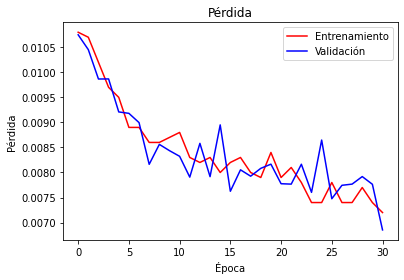

In [15]:
# función de pérdida
plt.plot(epoca, perdida, color='r')
plt.plot(epoca, perd_val1, color='b')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida")
plt.legend(["Entrenamiento", "Validación"])
plt.show()

Text(0.5, 1.0, 'Exactitud')

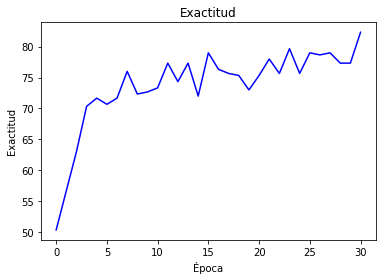

In [16]:
# precisión
plt.plot(epoca, exactitud, color='b')
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.title("Exactitud")

Evaluamos la exactitud del modelo con el set de prueba.

In [17]:
evaluar(cnn, loader_prueba, disp, criterio, mostrar=True)

Exactitud: 74.3333%


## Mostramos las imágenes

Ya hemos creado nuestra red neuronal convolucional, ahora lo único que nos falta es poder ver las imágenes y ver en que clase las ha puesto nuestra red.

Vamos a agregarle un límite de imágenes para que nos imprima, a este límite lo llamaremos **k**.

Como al principio las hemos convertido a *tensores* y las hemos normalizado, ahora es necesario revertir esa transformación para poderlas ver con **matplotlib**.

Vamos a crear una función para ilustrar este proceso. La función la llamaremos **mostrar_imagen**, y recibirá como parámetro un *data loader*, dentro de esta función estableceremos dos *tensores*, uno que corresponde a la media, **mean** y otro que corresponde a la desviación estándar, **std**. Les asignaremos los mismos valores que les asignamos a los utilizados para normalizar las imágenes. Después obtendremos las imágenes una a una y las multiplicaremos por **std** y les sumaremos **mean**. Con esto, ya hemos las hemos desnormalizado, ahora solo nos queda convertirlas a un ***array*** de *numpy*, transponerlas y graficarlas con **imshow** de *pyplot*

In [18]:
def mostrar_imagen(loader, k=-1):
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    # contador
    i = 0

    for imagenes, etiquetas in iter(loader):
        for imagen in imagenes:
            # incrementamos el contador
            i += 1
            # condición de paro
            if k > 0 and k < i:
                break
            # desnormalizamos la imagen
            img = imagen * std[:,None,None] + mean[:,None,None]
            plt.imshow(img.numpy().transpose(1, 2, 0))
            plt.show()
        # condición de paro
        if k > 0 and k < i:
            break

Probamos nuestra función **mostrar_imagen**

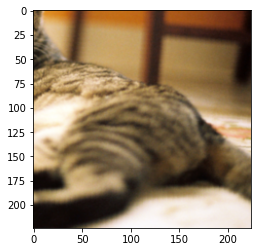

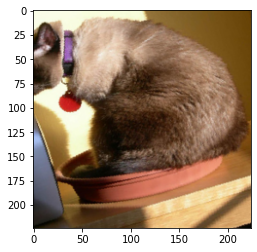

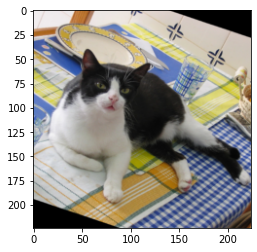

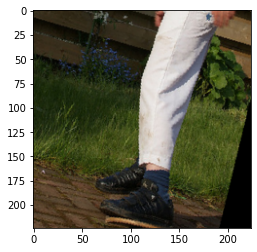

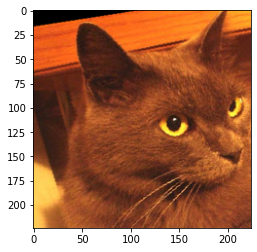

In [19]:
mostrar_imagen(loader_prueba, k=5)

Ya que que tenemos una función que nos muestra las imágenes, la vamos a combinar con la función **evaluar** para poder acceder a las predicciones de las mismas. 

Le daremos dos parámetros más a nuestra función evaluar, que serán **predecir**, por defecto en *False*, cuando lo mandemos como *True* nos imprimirá las imágenes junto con su etiqueta, y **k**, que es nuestro contador, por defecto en -1. Para ver su clase, utilizaremos el diccionario **clases**, que creamos previamente. De modo que dependiendo de si la clase es 1 o 0, podamos ver si se trata de un gato o no.

In [20]:
def evaluar(modelo, prueba, disp, criterio, mostrar=False, predecir=False, k=-1):

    # ponemos el modelo en modo de evaluacion
    modelo.eval()
    # inicializamos variables
    correctas = 0
    total = 0
    perdida_val = 0.0
    # inicializamos nuestro contador
    j = 0
    # obtenemos los datos del data loader
    for imagenes, etiquetas in iter(prueba):
        # copiamos los datos al dispositivo seleccionado (gpu o cpu)
        imagenes = imagenes.to(disp)
        etiquetas = etiquetas.to(disp)

        # obtenemos las salidas del modelo
        salidas = modelo(imagenes)

        # obtenemos las predicciones seleccionando la clase con la
        # mayor probabilidad
        predichos = torch.max(salidas.data, 1)[1]

        # acumulamos el número de datos
        total += len(etiquetas)

        # pérdida
        perdida_val += criterio(salidas, etiquetas).data
        # acumulamos las predicciones correctas
        correctas += (predichos == etiquetas).sum()

        # implementamos el método para ver las imágenes
        if predecir:
            if j < k or k == -1:
                # copiamos las imágenes a la cpu
                imagenes = imagenes.to('cpu')
                predichos = predichos.to('cpu')
                predichos = predichos.numpy()
                
                # indice de la predicción
                i = 0
                
                mean = torch.tensor([0.485, 0.456, 0.406])
                std = torch.tensor([0.229, 0.224, 0.225])
                
                for imagen in imagenes:
                    # incrementamos el contador
                    if k > 0:
                        j += 1
                    # desnormalizamos la imagen
                    img = imagen * std[:,None,None] + mean[:,None,None]
                    plt.imshow(img.numpy().transpose(1, 2, 0))
                    # obtenemos la predicción de la imagen
                    prediccion = clases.get(predichos[i])
                    # ponemos la predicción como título
                    plt.title(prediccion)
                    i += 1
                    plt.show()

    perdida_val = float(perdida_val/float(total))
    perdida_val = round(perdida_val, 4)
    # calculamos la exactitud
    exactitud = 100 * correctas / float(total)
    exactitud = round(float(exactitud), 4)

    if mostrar:
        print("Exactitud: {}%".format(exactitud))
    else:
        return exactitud, perdida_val

Ejecutamos **evaluar** con **predecir = *True*** y **k = 10**, para ver 10 imágenes.

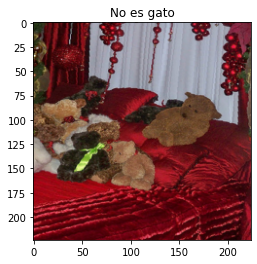

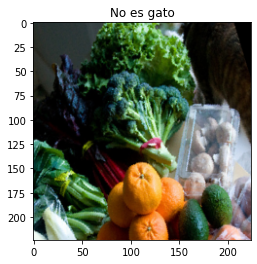

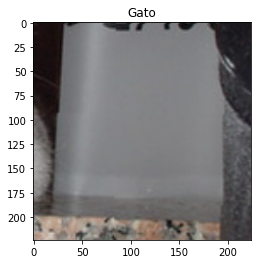

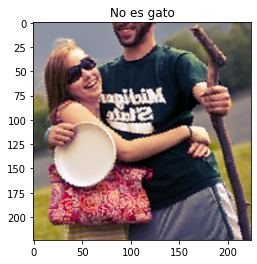

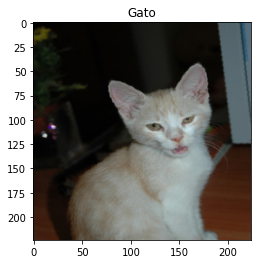

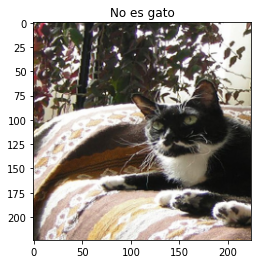

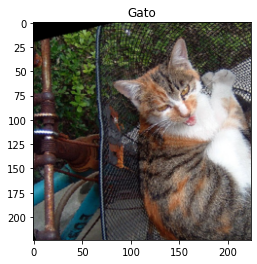

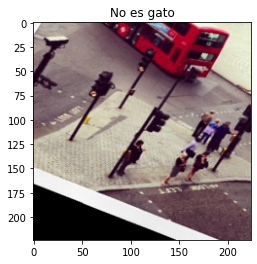

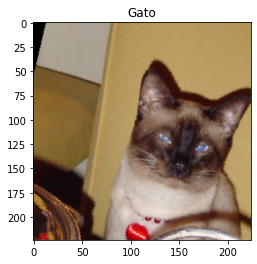

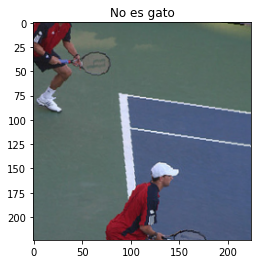

Exactitud: 73.3333%


In [21]:
evaluar(cnn, loader_prueba, disp, criterio, mostrar=True, predecir=True, k=10)

Ya hemos finalizado nuestra red neuronal convolucional, ahora, lo único que haremos será guardar nuestro modelo ya entrenado, por si después queremos volver a utilizarlo, no tengamos que entrenarlo de nuevo.

## Guardando el modelo

Para guardar el modelo, utilizaremos el comando **torch.save** y guardaremos tanto el modelo como el optimizador, con el propósito de no perder los pesos que ya hemos obtenido.

Se guardará en un archivo llamado **cnn_checkpoint.pth** en el mismo directorio que este programa.

In [22]:
torch.save({
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizador.state_dict(),
            }, "cnn_checkpoint.pth")

## Cargando el modelo

Para cargar el modelo, primero hay que instanciar la clase, establecer el criterio y el optimizador, y finalmente utilizar el comando **torch.load(ubicacion)**. Después restauramos los valores de la red. Con esto ya habremos cargado nuestra red entrenada y lista para usarse.

In [ ]:
# usamos una gpu si es que hay alguna disponible
disp = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# instanciamos la clase
cnn = CNN().to(disp)
# funcion de perdida
criterio = nn.CrossEntropyLoss()
# optimizador
optimizador = torch.optim.SGD(cnn.parameters(), lr=0.01)

# cargamos los valores previamente guardados
checkpoint = torch.load("cnn_checkpoint.pth")
cnn.load_state_dict(checkpoint['model_state_dict'])
optimizador.load_state_dict(checkpoint['optimizer_state_dict'])